In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()

await node.lock()

Node 5fd22109-7e01-4065-9ca2-9a71dffe7c8e

In [1]:
import Local_NAV as local
from Global_NAV_TERMINATOR_VERSION import *
import MotionCTR2 as mctrl
import Kal_FILTER as kfil
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import IPython
from IPython.display import display, clear_output
import time

from matplotlib import colors
from cvision_2 import *

%matplotlib inline

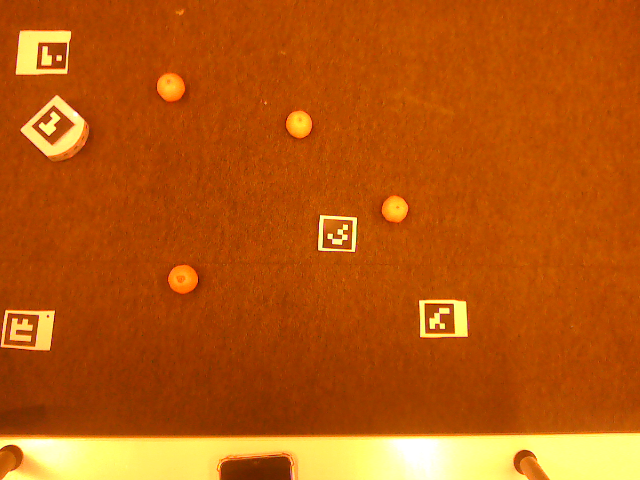

Goal position [[674.3111329  211.82045849]]


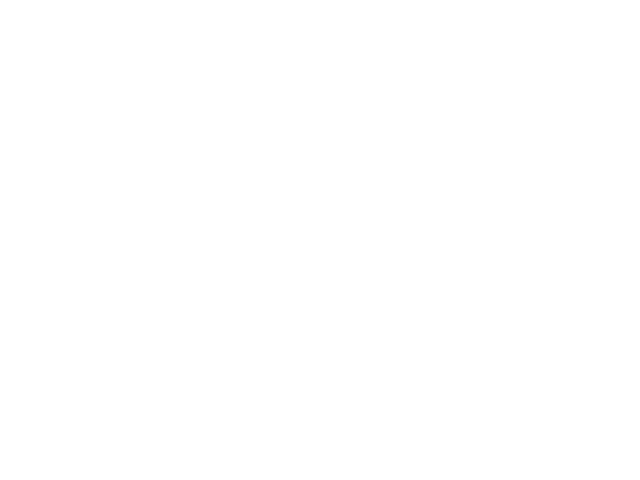

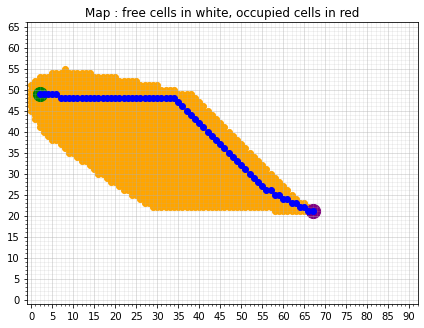

PATH :  [[ 20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180 190
  200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370
  380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550
  560 570 580 590 600 610 620 630 640 650 660 670]
 [490 490 490 490 490 480 480 480 480 480 480 480 480 480 480 480 480 480
  480 480 480 480 480 480 480 480 480 480 480 480 480 480 480 470 460 450
  440 430 420 410 400 390 380 370 360 350 340 330 320 310 300 290 280 270
  260 260 250 250 240 240 230 230 220 220 210 210]]
Key Points :  [[60, 340, 560, 630, 670], [490, 480, 260, 230, 210]]


NameError: name 'node' is not defined

In [2]:
#Global variables
state = 0
obst = [0,0,0,0,0]
motors_speed = [0,0]
not_arrived = True
k = 0
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137
L = 104
R = 20
Ts = 0.5 # sampling time
# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
threshold_for_convergence = 20
speed0 = 60
speedGain = 30

path = []
while True:
    if state == 0:
        # Create an adjusted dictionary of 5 markers of 4x4 bits.
        aruco_dictionary = cv2.aruco.extendDictionary(5, 4)
        # Assign a marker to each objects to be recognized on the map
        # Generate three reference markers
        detector = create_detector(aruco_dictionary)
       

        for i in range(5):
            marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
            cv2.imwrite('marker' + str(i) +'.jpg', marker)
        # Definition of the references used to map the space
        ref1 = Obj(0, np.array([[0,0]]))
        ref2 = Obj(1, np.array([[0,0]]))
        ref3 = Obj(2, np.array([[0,0]]))

       
        # Definition of the objects to recognize in the space
        goal = Obj(3, np.array([[]]))
        thymio = Obj(4, np.array([[]]))

        map = Map(ref1,ref2,ref3,920,660)

        objects = np.array([ref1,ref2, ref3, goal, thymio])

        # Open the video
        # For a livestream
        video = cv2.VideoCapture(0)
        # or with a prerecorded video
        #video = cv2.VideoCapture('test3.avi')
        if (video.isOpened()== False): 
            print("Error opening video stream or file")
        
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            if ret == True:
                clear_output(wait=True)
                show_frame(frame)

                detect_objects(frame, detector, objects)
                if map.references_detected():
                    print('Goal position', map.localize(goal))
                    matrix = map.matrix(frame, thymio, goal)

                    if check_matrix(matrix):
                        path, visitedNodes = global_path(matrix)
                        print_path(matrix, path, visitedNodes)
                        path = np.multiply(path, 10)
                        print("PATH : ",path)
                        key_points = calculate_angles_along_path(path)
                        print("Key Points : ",key_points)
                        N = np.size(path,1)
                        path_found = True
                        state_estimate_k = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])

        # Navigation
        state = 1    
        # Global navigation state
    if state == 1:
    
        while not_arrived == True:

            #Check if there is obstacles
            prox_horizontal = local.read_prox_sensors(node,client)
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            state = local.update_state(state,obst,client)
            if state == 2:
                break

            # Path following: control law
            print("Position final goal", [path[0,k],path[1,k]])
            vr, vl = mctrl.control_law(state_estimate_k, key_points[0,k], key_points[1,k],speed0,speedGain)
            #control_vector_k_minus_1 = mctrl.convert_velocity2vw(vr,vl,C_conv_toThymio_right, C_conv_toThymio_left,L,R) if we use [v,w] as control variables in state space model
            control_vector_k_minus_1 = np.array([vr,vl]) #if we use [vr,vl] as control variables in state space model
            print("Control vector", control_vector_k_minus_1)
            mctrl.set_motors(vl,vr,node)
            
            
            # Take Thymio position if camera is not obstructed and update state estimate with kalman filter
            if video.isOpened:
                ret, frame = video.read()
                new_frame = frame.copy()
                if ret == True:
                    
                    #clear_output(wait=True)
                    detect_objects(frame, detector, objects)
                    
                    ref1.draw(new_frame, [255,0,0])
                    ref2.draw(new_frame, [0,255,0])
                    ref3.draw(new_frame, [0,0,255])
                    goal.draw(new_frame, [255,255,255])
                    thymio.draw(new_frame, [255,0,0])
                    #show_frame(new_frame)
                    
                    
                    if map.references_detected(): #camera correctly working

                        
                        if np.size(map.localize(thymio), 0) > 0: #camera working correctly
                            camera_obstructed = 0
                            #take robot position from camera
                            z_k_observation_vector = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])  
                            print("Robot position and angle (rad)", z_k_observation_vector)  
                            # update state estimate with kalman filter
                            #state_estimate_k = z_k_observation_vector #if you don't use kalman filter
                            state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed)
                            print("State_estimate_k", state_estimate_k)
                        else: #camera obstructed
                            camera_obstructed = 1
                            print("WARNING:NOCAMERA--WARNING:NOCAMERA--WARNIN:NOCAMERA--WARNING:NOCAMERA")
                            #Measurements are not updated by camera but only by kalman filter
                            state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed) 
            
            # Check if the robot has arrived to the temporary goal
            if np.linalg.norm(state_estimate_k[:2] - np.array([key_points[0,k], key_points[1,k]])) < threshold_for_convergence:
                if k ==  len(key_points[0]):
                    not_arrived = False
                    print('The robot has arrived to the final goal')
                    mctrl.stop_motors(node)
                    #break
                else :
                    k = k + 1
                print("position {} of {} in path: ".format(k,N-1))
                

 
            time.sleep(Ts)   


    # Local navigation state
    if state == 2:         
        #We get the sensor value
        prox_horizontal = local.read_prox_sensors(node,client)
        
        #We fill the obst list with the sensor value
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        
        #We calculate the motor speed to avoid the object -> potential field method
        motors_speed = local.local_navigation(obst)
        
        #We set the motor speed
        mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
        #We update the state
        state = local.update_state(state,obst,client)
        if state == 1:
            state_estimate_k = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])
            closest_index = find_closest_keypoint_index(state_estimate_k[:2], key_points)
            angle = calculate_angle_between_robot_and_closest(state_estimate_k[:2], key_points, closest_index)
            
            while angle > 90:
                if  closest_index != len(key_points[0]) - 1 :
                    distances = calculate_distances_to_keypoints(state_estimate_k[:2], key_points)
                    next_closest_index = find_next_closest_keypoint(state_estimate_k[:2], key_points, distances, closest_index)
                    closest_index = next_closest_index
                    angle_to_closest = calculate_angle_between_robot_and_closest(state_estimate_k[:2], key_points, closest_index)
                else :
                    break

        closest_keypoint = [[key_points[0][closest_index]],[key_points[1][closest_index]]]
        vr, vl = mctrl.control_law(state_estimate_k, closest_keypoint[0], closest_keypoint[1],speed0,speedGain)
        mctrl.set_motors(vl,vr,node)


            
            
            
            
             
            

       


In [ ]:
motors_speed = local.global_path()
local.set_motors(motors_speed[0],motors_speed[1],node) 
local.stop_motors(node) 


AttributeError: module 'Local_NAV' has no attribute 'global_path'

In [ ]:
mctrl.stop_motors(node)

In [13]:
import numpy as np

def find_key_points(path):
    key_points = []
    if len(path[0]) < 3:
        print("Length of path array is less than 3")
        return key_points
    for i 

    return key_points

# Example path
path = [[1, 2, 1, 1, 1], [1, 2, 3, 4, 5]]
key_points = find_key_points(path)
print("Key Points:", key_points)


Key Points: []


In [15]:
import numpy as np

def calculate_angle(A, B, C):
    vector_AB = np.array(B) - np.array(A)
    vector_BC = np.array(C) - np.array(B)

    dot_product = np.dot(vector_AB, vector_BC)
    magnitude_AB = np.linalg.norm(vector_AB)
    magnitude_BC = np.linalg.norm(vector_BC)

    cos_angle = dot_product / (magnitude_AB * magnitude_BC)
    angle_rad = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)

    return angle_deg

# Example points A, B, C
point_A = [1, 1]
point_B = [2, 2]
point_C = [1, 3]

angle_at_B = calculate_angle(point_A, point_B, point_C)
print("Angle at point B:", angle_at_B)

Angle at point B: 90.0


In [28]:
def calculate_angles_along_path(path):
    key_points = [[], []]
    angle_TH = 45
    x_coords, y_coords = path[0], path[1]
    path_length = len(x_coords)

    if path_length < 3 or len(y_coords) != path_length:
        print("Invalid path format.")
        return angles

    for i in range(path_length - 2):
        point_A = [x_coords[i], y_coords[i]]
        point_B = [x_coords[i + 1], y_coords[i + 1]]
        point_C = [x_coords[i + 2], y_coords[i + 2]]

        angle_at_point = calculate_angle(point_A, point_B, point_C)
        if(angle_at_point > angle_TH):
            key_points[0].append(point_B[0])
            key_points[1].append(point_B[1]) 
            
            
    key_points[0].append(x_coords[-1])
    key_points[1].append(y_coords[-1])
            
    return key_points

# Example path with X and Y coordinates
example_path = [
    [1, 2, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
]

angles_along_path = calculate_angles_along_path(example_path)
print("Angles at each point:", angles_along_path)

Angles at each point: [[2, 1, 1, 0, 0], [2, 3, 5, 6, 10]]


In [39]:
import numpy as np

def distance_between_points(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def calculate_distances_to_keypoints(robot_position, key_points):
    distances = []

    for i in range(len(key_points[0])):
        distance = distance_between_points(robot_position, [key_points[0][i], key_points[1][i]])
        distances.append(distance)

    return distances

# Example robot position and key_points array
robot_position = [3, 3]
key_points = [
    [2,2, 2, 5],
    [2,3, 5, 8]
]


distances_to_keypoints = calculate_distances_to_keypoints(robot_position, key_points)
print("Distances to key points:", distances_to_keypoints)

Distances to key points: [1.4142135623730951, 1.0, 2.23606797749979, 5.385164807134504]


In [40]:
import numpy as np

def distance_between_points(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def calculate_distances_to_keypoints(robot_position, key_points):
    distances = []

    for i in range(len(key_points[0])):
        distance = distance_between_points(robot_position, [key_points[0][i], key_points[1][i]])
        distances.append(distance)

    return distances

def find_closest_keypoint_index(robot_position, key_points):
    distances = calculate_distances_to_keypoints(robot_position, key_points)
    closest_index = np.argmin(distances)
    return closest_index

# Example robot position and key_points array
robot_position = [3, 3]
key_points = [
    [2,2, 2, 5],
    [2,3, 5, 8]
]


closest_index = find_closest_keypoint_index(robot_position, key_points)
closest_keypoint = [
    [key_points[0][closest_index]],
    [key_points[1][closest_index]]
]

print("Closest key point:", closest_keypoint)

Closest key point: [[2], [3]]


In [41]:
import numpy as np

def distance_between_points(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def calculate_angle(A, B, C):
    vector_AB = np.array(B) - np.array(A)
    vector_BC = np.array(C) - np.array(B)

    dot_product = np.dot(vector_AB, vector_BC)
    magnitude_AB = np.linalg.norm(vector_AB)
    magnitude_BC = np.linalg.norm(vector_BC)

    cos_angle = dot_product / (magnitude_AB * magnitude_BC)
    angle_rad = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)

    return angle_deg

def calculate_angle_between_robot_and_closest(robot_position, key_points, closest_index):
    closest_keypoint = [key_points[0][closest_index], key_points[1][closest_index]]

    angle = calculate_angle(closest_keypoint, robot_position, [0, 0])
    return angle

# Example robot position and key_points array
robot_position = [3,3]
key_points = [
    [2,2, 2, 5],
    [2,3, 5, 8]
]

closest_index = find_closest_keypoint_index(robot_position, key_points)
angle_to_closest = calculate_angle_between_robot_and_closest(robot_position, key_points, closest_index)
print("clos",closest_keypoint)
print("Angle between robot and closest key point:", angle_to_closest)

clos [[2], [3]]
Angle between robot and closest key point: 135.0


In [42]:
import numpy as np

def distance_between_points(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def calculate_angle(A, B, C):
    vector_AB = np.array(B) - np.array(A)
    vector_BC = np.array(C) - np.array(B)

    dot_product = np.dot(vector_AB, vector_BC)
    magnitude_AB = np.linalg.norm(vector_AB)
    magnitude_BC = np.linalg.norm(vector_BC)

    cos_angle = dot_product / (magnitude_AB * magnitude_BC)
    angle_rad = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)

    return angle_deg

def calculate_angle_between_robot_and_closest(robot_position, key_points, closest_index):
    closest_keypoint = [key_points[0][closest_index], key_points[1][closest_index]]

    angle = calculate_angle(closest_keypoint, robot_position, [0, 0])
    return angle

def find_next_closest_keypoint(robot_position, key_points, distances, closest_index):
    angles = []
    for i in range(len(key_points[0])):
        if i != closest_index:
            angle = calculate_angle_between_robot_and_closest(robot_position, key_points, i)
            angles.append(angle)
        else:
            angles.append(360)  # Ensuring the closest key point isn't considered again

    next_closest_index = np.argmin(angles)
    return next_closest_index

# Example robot position and key_points array
robot_position = [5, 10]
key_points = [
    [2, 4, 6, 8, 10],
    [3, 6, 9, 12, 15]
]

closest_index = find_closest_keypoint_index(robot_position, key_points)
angle_to_closest = calculate_angle_between_robot_and_closest(robot_position, key_points, closest_index)

if angle_to_closest > 90 and closest_index != len(key_points[0]) - 1:
    distances = calculate_distances_to_keypoints(robot_position, key_points)
    next_closest_index = find_next_closest_keypoint(robot_position, key_points, distances, closest_index)
    closest_index = next_closest_index
    angle_to_closest = calculate_angle_between_robot_and_closest(robot_position, key_points, closest_index)

closest_keypoint = [
    [key_points[0][closest_index]],
    [key_points[1][closest_index]]
]

print("Angle between robot and closest key point:", angle_to_closest)
print("Closest key point:", closest_keypoint)

Angle between robot and closest key point: 18.434948822922017
Closest key point: [[10], [15]]


In [5]:
def remove_point(key_points, position):
    x, y = position  # Assuming position is a tuple (x, y)
    
    for coordinates in key_points:
        if [x, y] in zip(*key_points):
            index_to_remove = key_points[0].index(x)
            for coordinates in key_points:
                del coordinates[index_to_remove]
            return True  # Point removed
    return False  # Point not found

# Example usage:
key_points = [
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10]
]

robot_position = [[2],[7]]# Robot's position
print("kkkk",key_points)

removed = remove_point(key_points, robot_position)
if removed:
    print(f"Point {robot_position} removed from key_points")
else:
    print(f"Point {robot_position} not found in key_points")

kkkk [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]
Point [[2], [7]] not found in key_points
